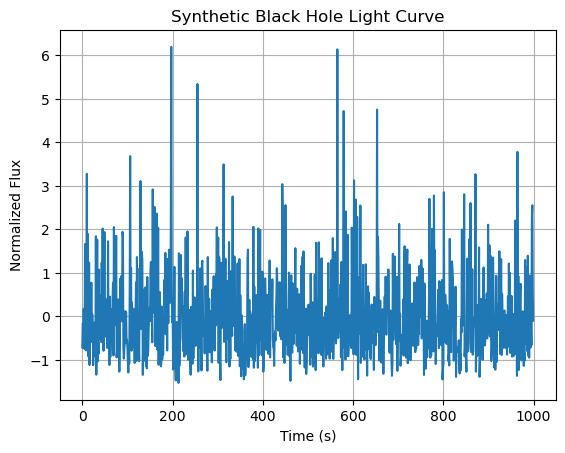

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

mean = 0
std = 0.5
num_samples = 1000 #length of the time series 5000 would be more

# Replace with real XMM-Newton data loader.
def simulate_black_hole_lightcurve(duration=num_samples, dt=1, qpo_freq=0.03, qpo_amplitude=1, noise_level=0.2):
    """
    Simulate a light curve with stochastic noise + periodic signal (QPO). 
    """
    # Time array
    t = np.arange(0, duration, dt)
    
    # Stochastic random walk (red noise) => 
    white_noise = np.random.normal(mean, std, size=len(t))

    # exponetiate
    white_noise = np.exp(white_noise)


    # QPO signal (damped sinusoid)
    # qpo = qpo_amplitude * np.sin(2 * np.pi * qpo_freq * t) 
    # * np.exp(-0.001 * t)
    
    # Combine
    flux = white_noise 
    # + qpo 
    
    # Normalize
    flux = (flux - np.mean(flux)) / np.std(flux)
    
    return t, flux



# Generate synthetic data
t, flux = simulate_black_hole_lightcurve(qpo_freq=0.15, qpo_amplitude=0.5)
plt.plot(t, flux)
plt.xlabel("Time (s)")
plt.ylabel("Normalized Flux")
plt.title("Synthetic Black Hole Light Curve")
plt.grid(True)
plt.show()

[0.06981843 0.04284965 0.05282423 0.01115393 0.01663023 0.09655532
 0.05675913 0.03624507 0.00737075 0.02823051 0.11176063 0.02071399
 0.06127497 0.05873837 0.04526965 0.06780878 0.05351267 0.05261973
 0.03513261 0.04119587 0.05362034 0.04196229 0.03485459 0.09838493
 0.00887205 0.04600826 0.02885117 0.08207006 0.074057   0.0595025
 0.01000808 0.04926062 0.10567167 0.04502351 0.08182829 0.13167452
 0.06671852 0.09285007 0.04647931 0.06710428 0.02701105 0.11314201
 0.04680041 0.04806291 0.05834414 0.0153603  0.05210834 0.07016089
 0.0605407  0.07404468 0.01137934 0.09364549 0.01411716 0.04256481
 0.05528963 0.02232497 0.04255    0.0172702  0.09083159 0.04843034
 0.08736488 0.04199807 0.08722786 0.04661594 0.01930631 0.0847543
 0.08103436 0.0915235  0.06139696 0.02244172 0.06760741 0.04409115
 0.05056947 0.06042247 0.03990734 0.04207805 0.09511679 0.05607067
 0.09019157 0.06588236 0.03912126 0.07883709 0.06753087 0.06248158
 0.03290287 0.04872975 0.04893666 0.10054797 0.02744182 0.092951

<Figure size 640x480 with 0 Axes>

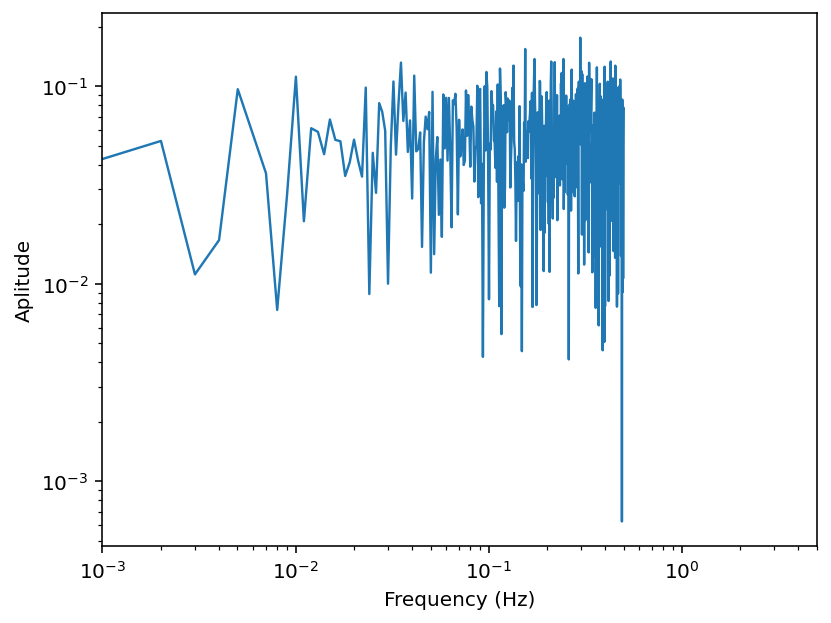

In [16]:
from scipy.fftpack import fft as fft
from matplotlib.ticker import *
 
 
# Number of samplepoints (number of time bins in the time series)
N = 1000
N = int(N)
# sample spacing (size of the time step)
T = 1.0# / 1000.0
 
# set up an array of times
x = np.linspace(0.0, N*T, N)
#compute the Fast Fourier Transform of y
yf = fft(flux)
 
 
# make the Periodogram by taking the modulus squared - the abs() function
# and multiplying by a normalsing factor (2.0/N in this case)
 
per = 2.0/N * (np.abs(yf))
 
# Make sure we select the positive frequenices only, and lose teh zero frequency
per = per[1:int(N/2)]
 
# make an array of Fourier frequencies
xf = np.linspace(0.0, 1.0/(2.0*T), int(N/2)-1)
 

print(per)
 
plt.figure(1)
fig, ax = plt.subplots(dpi=144)
 
 
# plt.subplot(212)
plt.plot(xf, per, linewidth=1.2)                 
plt.xlim(0.001,5.0)# zoom in
plt.xlabel(r'Frequency (Hz)', fontsize=10)
plt.ylabel(r'Aplitude', fontsize=10)
# ax.set_xscale('log')

ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.models import Model, Sequential

# Hyperparameters
SEQ_LENGTH = 100  # Length of input sequences
LATENT_DIM = 32   # Noise vector size

# Generator (LSTM-based)


def build_generator():
    model = Sequential([
        Input(shape=(LATENT_DIM,)),
        Dense(64, activation='relu'),
        Dense(128, activation='relu'),
        Dense(SEQ_LENGTH, activation='tanh'),  # Output sequence
        tf.keras.layers.Reshape((SEQ_LENGTH, 1))
    ])
    return model

# Discriminator (LSTM-based)


def build_discriminator():
    model = Sequential([
        Input(shape=(SEQ_LENGTH, 1)),
        LSTM(64, return_sequences=True),
        LSTM(32),
        Dense(1, activation='sigmoid')
    ])
    return model

# GAN


class BlackHoleGAN(Model):
    def __init__(self, generator, discriminator):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super().compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_sequences):
        # Train discriminator
        noise = tf.random.normal((tf.shape(real_sequences)[0], LATENT_DIM))
        fake_sequences = self.generator(noise)

        with tf.GradientTape() as d_tape:
            real_pred = self.discriminator(real_sequences)
            fake_pred = self.discriminator(fake_sequences)
            d_loss_real = self.loss_fn(tf.ones_like(real_pred), real_pred)
            d_loss_fake = self.loss_fn(tf.zeros_like(fake_pred), fake_pred)
            d_loss = d_loss_real + d_loss_fake

        d_grads = d_tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(d_grads, self.discriminator.trainable_weights))

        # Train generator
        with tf.GradientTape() as g_tape:
            fake_sequences = self.generator(noise)
            fake_pred = self.discriminator(fake_sequences)
            g_loss = self.loss_fn(tf.ones_like(fake_pred), fake_pred)

        g_grads = g_tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(g_grads, self.generator.trainable_weights))

        return {"d_loss": d_loss, "g_loss": g_loss}


# Initialize models
generator = build_generator()
discriminator = build_discriminator()
gan = BlackHoleGAN(generator, discriminator)

# Compile
gan.compile(
    g_optimizer=tf.keras.optimizers.Adam(1e-4),
    d_optimizer=tf.keras.optimizers.Adam(1e-4),
    loss_fn=tf.keras.losses.BinaryCrossentropy()
)

KeyboardInterrupt: 

Epoch 1/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - d_loss: 1.3846 - g_loss: 0.6943
Epoch 2/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - d_loss: 1.3949 - g_loss: 0.7031
Epoch 3/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - d_loss: 1.3821 - g_loss: 0.7535
Epoch 4/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - d_loss: 1.1627 - g_loss: 1.2051
Epoch 5/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - d_loss: 0.6679 - g_loss: 1.7231
Epoch 6/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - d_loss: 0.7904 - g_loss: 1.9564
Epoch 7/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - d_loss: 1.3087 - g_loss: 0.9380
Epoch 8/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - d_loss: 1.3732 - g_loss: 0.8231
Epoch 9/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - d_loss: 1.4126 - g_loss: 0.7325
Epoch 10/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - d_loss: 1.4199 - g_loss: 0.7189
Epoch 11/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - d_loss: 1.4171 - g_loss: 0.7162
Epoch 12/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 

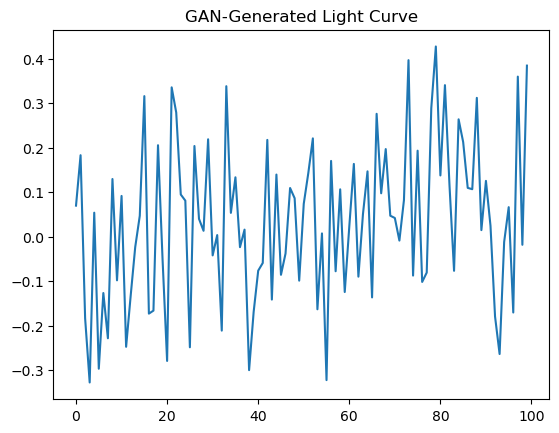

In [3]:
# Generate training sequences from synthetic data
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
    return np.array(sequences)

# Generate synthetic dataset
_, flux = simulate_black_hole_lightcurve(duration=5000)
sequences = create_sequences(flux, SEQ_LENGTH)
dataset = tf.data.Dataset.from_tensor_slices(sequences.reshape(-1, SEQ_LENGTH, 1)).batch(32)

# Train
history = gan.fit(dataset, epochs=50)

# Generate sample
noise = tf.random.normal((1, LATENT_DIM))
generated_sequence = generator(noise).numpy().flatten()
plt.plot(generated_sequence)
plt.title("GAN-Generated Light Curve")
plt.show()

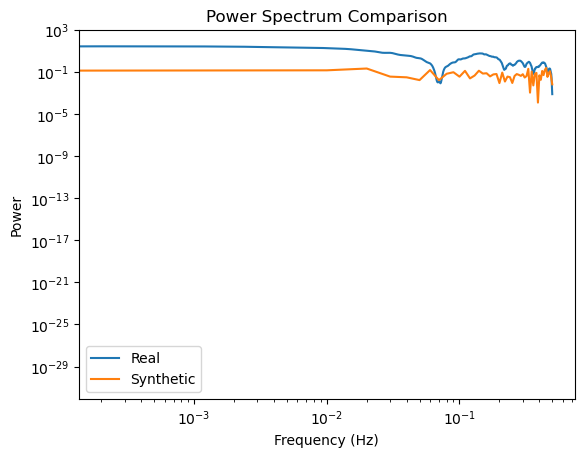

/var/folders/15/7vdcd9756072lbp614rqt18c0000gn/T/ipykernel_34176/3089252679.py:16: RuntimeWarning: invalid value encountered in log
  plt.hist(np.log(real_data), bins=50, alpha=0.5, label='Real')
/var/folders/15/7vdcd9756072lbp614rqt18c0000gn/T/ipykernel_34176/3089252679.py:17: RuntimeWarning: invalid value encountered in log
  plt.hist(np.log(synthetic_data), bins=50, alpha=0.5, label='Synthetic')


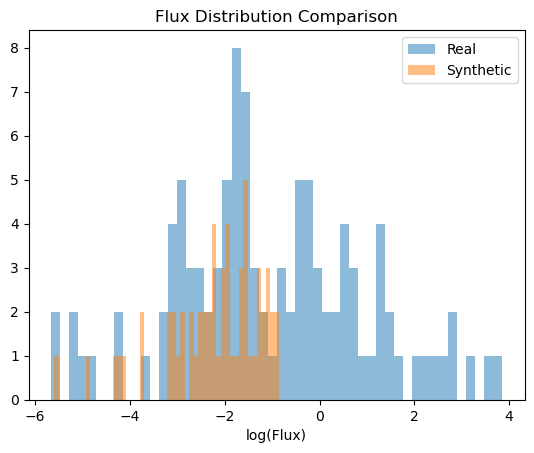

In [4]:
def validate_synthetic(real_data, synthetic_data):
    # Power spectrum comparison
    from scipy.signal import periodogram
    f_real, P_real = periodogram(real_data)
    f_syn, P_syn = periodogram(synthetic_data)
    
    plt.loglog(f_real, P_real, label='Real')
    plt.loglog(f_syn, P_syn, label='Synthetic')
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power")
    plt.title("Power Spectrum Comparison")
    plt.legend()
    plt.show()

    # Distribution comparison
    plt.hist(np.log(real_data), bins=50, alpha=0.5, label='Real')
    plt.hist(np.log(synthetic_data), bins=50, alpha=0.5, label='Synthetic')
    plt.xlabel("log(Flux)")
    plt.title("Flux Distribution Comparison")
    plt.legend()
    plt.show()

validate_synthetic(flux, generated_sequence)